In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy as sc
from scipy import random, linalg, stats, special

random.seed(1234)
np.random.seed(1234)
# parameters
NProperties = 1
NClasses = 4
NObjects = 200
distanceBTWclasses = 20
DiffBTWSpreadOFclasses = 2

# The mean vector
Mu = [np.random.random(NProperties)*distanceBTWclasses*i for i in range(1,NClasses+1)]
# the sd vector
Var = [np.random.random(NProperties)*DiffBTWSpreadOFclasses*i for i in range(1,NClasses+1)]

# (1)
# we can have symmetric dirichlet that put a same amount of probability to each classes appearance probability
theta = np.repeat(1.0/NClasses,NClasses)
print ('The probabilities of each classes from 1 to '+str(NClasses))
print (theta)

# (2)
# generate the class from a multinomial distribution with parameter theta
r = np.random.multinomial(NObjects,theta)
print ('The number of objects in each classes from 1 to '+str(NClasses))
print (r)

# (3)
rAlln = [np.random.normal(Mu[i], Var[i], r[i]) for i in range(0,NClasses)]

# putting the generated data into an array form
y = rAlln[0]
for i in range(NClasses-1):
    y = np.hstack((y,rAlln[i+1]))

# Getting the true classes of the points 
v_true = np.zeros((1)) 
for i,j in enumerate(r):
    v_true = np.hstack((v_true, np.repeat(i+1, j)))
v_true = np.array(v_true[1:])
y_true = np.vstack((y, v_true))
# random shuffle the data points
np.random.shuffle(y_true.T)

y = y_true[0,:]

print ('The data shape:')
print (y.shape)

The probabilities of each classes from 1 to 4
[0.25 0.25 0.25 0.25]
The number of objects in each classes from 1 to 4
[60 50 47 43]
The data shape:
(200,)


In [2]:


def EStep(y, w, Mu, Sigma):
    
    r_ij = np.zeros((y.shape[0], Mu.shape[0]))
    
    for Object in range(y.shape[0]):
        
        r_ij_Sumj = np.zeros(Mu.shape[0])
        
        for jClass in range(Mu.shape[0]):
            r_ij_Sumj[jClass] = w[jClass] * sc.stats.norm.pdf(y[Object], Mu[jClass], np.sqrt(Sigma[jClass]))
        
        for jClass in range(r_ij_Sumj.shape[0]):
            r_ij[Object,jClass] =   r_ij_Sumj[jClass] / np.sum(r_ij_Sumj)
        
    return r_ij


def MStep(r, y, Mu, Sigma):
    
    N = y.shape[0]
    
    mu_j = np.zeros((N, Mu.shape[0]))
    sigma_j = np.zeros((N, Mu.shape[0]))
    
    for Object in range(y.shape[0]):
        
        # mean
        mu_j[Object,:] = r[Object,:] * y[Object]
        
        # sd
        sigma_j[Object,:] = r[Object,:] * np.square(-Mu + y[Object])

    w_j = np.sum(r, axis=0) / N
    mu_j = (1/np.sum(r, axis=0)) * np.sum(mu_j, axis=0)
    sigma_j = (1/np.sum(r, axis=0)) * np.sum(sigma_j, axis=0)
    
    return w_j,mu_j,sigma_j


Inititeration = 10
EMiteration = 200
lookLH = 20



for init in range(Inititeration):
    
    # starting values
    broadness = 15
    initVar = np.random.random(NClasses)+broadness
    initW = np.random.random(NClasses)
    initW = initW / np.sum(initW)
    initMu = np.random.random(NClasses)*max(y)

    r_n = EStep(y, initW, initMu, initVar)
    w_n,mu_n,sigma_n = MStep(r_n, y, initMu, initVar)
    
    if init == 0:
        logLH = -1000000000000
        
    for i in range(EMiteration):

        # E step
        r_n = EStep(y, w_n, mu_n, sigma_n)

        # M step
        w_n,mu_n,sigma_n = MStep(r_n, y, mu_n, sigma_n)

        # compute log likelihood
        logLall = np.zeros((y.shape[0]))

        for Object in range(y.shape[0]):

            LH = np.zeros(NClasses)

            for jClass in range(NClasses):
                LH[jClass] = w_n[jClass] * sc.stats.norm.pdf(y[Object], mu_n[jClass], np.sqrt(sigma_n[jClass]))

            logLall[Object] = np.log(np.sum(LH))

        logL = np.sum(logLall)

     #   if i > EMiteration - lookLH:
     #       print (i,':',logL)

    if logL > logLH:
        logLH = logL
        print ('found larger: ', logLH)
        w_p = w_n
        mu_p = mu_n
        sigma_p = sigma_n
        r_p = r_n

found larger:  -636.3738804234547


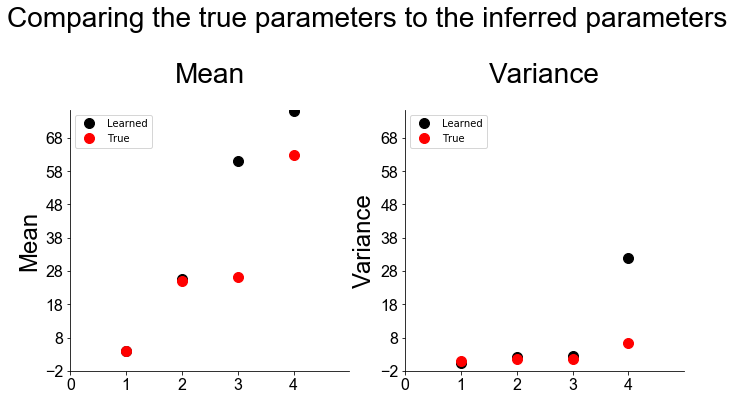

In [3]:
Mu_inf = np.sort(mu_p)
Mu_true = np.sort([Mu[i][0] for i in range(len(Mu))])

Var_inf = np.sort(sigma_p)
Var_true = np.sort([Var[i][0] for i in range(len(Var))])

# the figures
# parameters
plotsize = 11
sizeMean = 20
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font = {'fontname':'Arial', 'size':'28'}
x = range(1,NClasses+1)
startx = 0
endx = 5
stepsizex = 1
starty = -2
endy = max(y)
stepsizey = 10

# figure
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
#means
ax1.plot(x, Mu_inf, 'k.', markersize=sizeMean, label='Learned')
ax1.plot(x, Mu_true, 'r.', markersize=sizeMean, label='True')
#means
ax2.plot(x, Var_inf, 'k.', markersize=sizeMean, label='Learned')
ax2.plot(x, Var_true, 'r.', markersize=sizeMean, label='True')
          
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks(np.arange(startx, endx, stepsizex))
ax1.yaxis.set_ticks(np.arange(starty, endy, stepsizey))
ax1.set_xlim([startx, endx])
ax1.set_ylim([starty, endy])
ax1.set_ylabel('Mean', **axis_font)
ax1.legend(loc='upper left',fontsize=text_size-6)
ax1.set_title('Mean', y=1.08, **Title_font)
ax1.figure.set_size_inches(plotsize,plotsize)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks(np.arange(startx, endx, stepsizex))
ax2.yaxis.set_ticks(np.arange(starty, endy, stepsizey))
ax2.set_xlim([startx, endx])
ax2.set_ylim([starty, endy])
ax2.set_ylabel('Variance', **axis_font)
ax2.legend(loc='upper left',fontsize=text_size-6)
ax2.set_title('Variance', y=1.08, **Title_font)
ax2.figure.set_size_inches(plotsize,plotsize)

plt.suptitle('Comparing the true parameters to the inferred parameters',**Title_font)
fig.subplots_adjust(top=0.85)
plt.show()

In [4]:
print ('The inferred parameters')
print ('Mixing proportion: ',w_p)
print ('Means: ',mu_p)
print ('Variances: ',sigma_p)

print ('The True parameters')
print ('Mixing proportion: ',theta)
print ('Means: ',Mu)
print ('Variances: ',Var)
GoodOrder = [2,1,0,3]
r_ordered = r_p[:,GoodOrder] 
infClusters = np.argmax(r_ordered, axis=1)
Clustering = y_true[1]==infClusters+1
print ('Clustering accuracy: ',np.mean(Clustering))

The inferred parameters
Mixing proportion:  [0.20142503 0.48499998 0.3        0.01357498]
Means:  [61.08971749 25.63183676  3.93745015 76.00911892]
Variances:  [31.82513189  2.50504499  2.07780155  0.36354143]
The True parameters
Mixing proportion:  [0.25 0.25 0.25 0.25]
Means:  [array([3.83038901]), array([24.88435084]), array([26.26366434]), array([62.8286867])]
Variances:  [array([1.55995162]), array([1.09037042]), array([1.65878553]), array([6.41497742])]
Clustering accuracy:  0.565
